In [1]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import interp1d
from numpy.random import seed


In [2]:
n_slices = 9

In [3]:
filenames = [
    'Data/Slices/AgeSlices/CIS/Jaccard_slice_' + str(i) + '.csv' for i in range(n_slices)
]

jaccards_df = [
    pd.read_csv(filename) for filename in filenames
]

In [4]:
jaccards_df = [
    df.rename({df.columns[0]: 'symptom'}, axis='columns')
    for df in jaccards_df
    ]

In [5]:
jaccard_matrices = [df.loc[:, df.columns != 'symptom'].values for df in jaccards_df]

In [6]:
symptoms = jaccards_df[0].loc[:, jaccards_df[0].columns == 'symptom']
lookup = pd.read_csv('Data/Lookups/SymptomNameCategoryLookup.csv')
lookup = lookup.loc[lookup.dataset == 'ONS']
lookup = pd.merge(symptoms, lookup, left_on='symptom', right_on='symptom_name_raw')

In [7]:
lookup

,symptom,symptom_dataset_id,dataset,symptom_name_raw,symptom_name_formatted,symptom_id,category,category_id
0,sympt_now_fever,59,ONS,sympt_now_fever,Fever,2,Systemic,5.0
1,sympt_now_muscle_ache_myalgia,60,ONS,sympt_now_muscle_ache_myalgia,Muscle ache,9,Systemic,5.0
2,sympt_now_fatigue_weakness,61,ONS,sympt_now_fatigue_weakness,Fatigue,5,Systemic,5.0
3,sympt_now_sore_throat,62,ONS,sympt_now_sore_throat,Sore throat,16,Upper respiratory tract,3.0
4,sympt_now_cough,63,ONS,sympt_now_cough,Cough,1,Lower respiratory tract,4.0
5,sympt_now_shortness_of_breath,64,ONS,sympt_now_shortness_of_breath,Shortness of breath,22,Lower respiratory tract,4.0
6,sympt_now_headache,65,ONS,sympt_now_headache,Headache,6,Systemic,5.0
7,sympt_now_nausea_vomiting,66,ONS,sympt_now_nausea_vomiting,Nausea/vomiting,41,Gastrointestinal,1.0
8,sympt_now_abdominal_pain,67,ONS,sympt_now_abdominal_pain,Abdominal pain,24,Gastrointestinal,1.0
9,sympt_now_diarrhoea,68,ONS,sympt_now_diarrhoea,Diarrhoea,4,Gastrointestinal,1.0


In [8]:
relationship_dict = {i:i for i in range(symptoms.shape[0] - 1)}
relationships = [relationship_dict.copy() for i in range(n_slices - 1)]

In [9]:
seed(42)

aligned_mapper = umap.AlignedUMAP(
    n_neighbors=[4]*n_slices,
    min_dist = 0.1,
    n_components = 2,
    alignment_window_size=3,
    alignment_regularisation=1.5e-3,
    random_state=42,
    metric='precomputed')

# perform the alignment
aligned_mapper.fit(jaccard_matrices, relations = relationships)

AlignedUMAP(alignment_regularisation=0.0015, metric='precomputed',
            n_neighbors=[4, 4, 4, 4, 4, 4, 4, 4, 4], random_state=42)

In [10]:
# utility function to find create some useable axis
def axis_bounds(embedding):
    
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

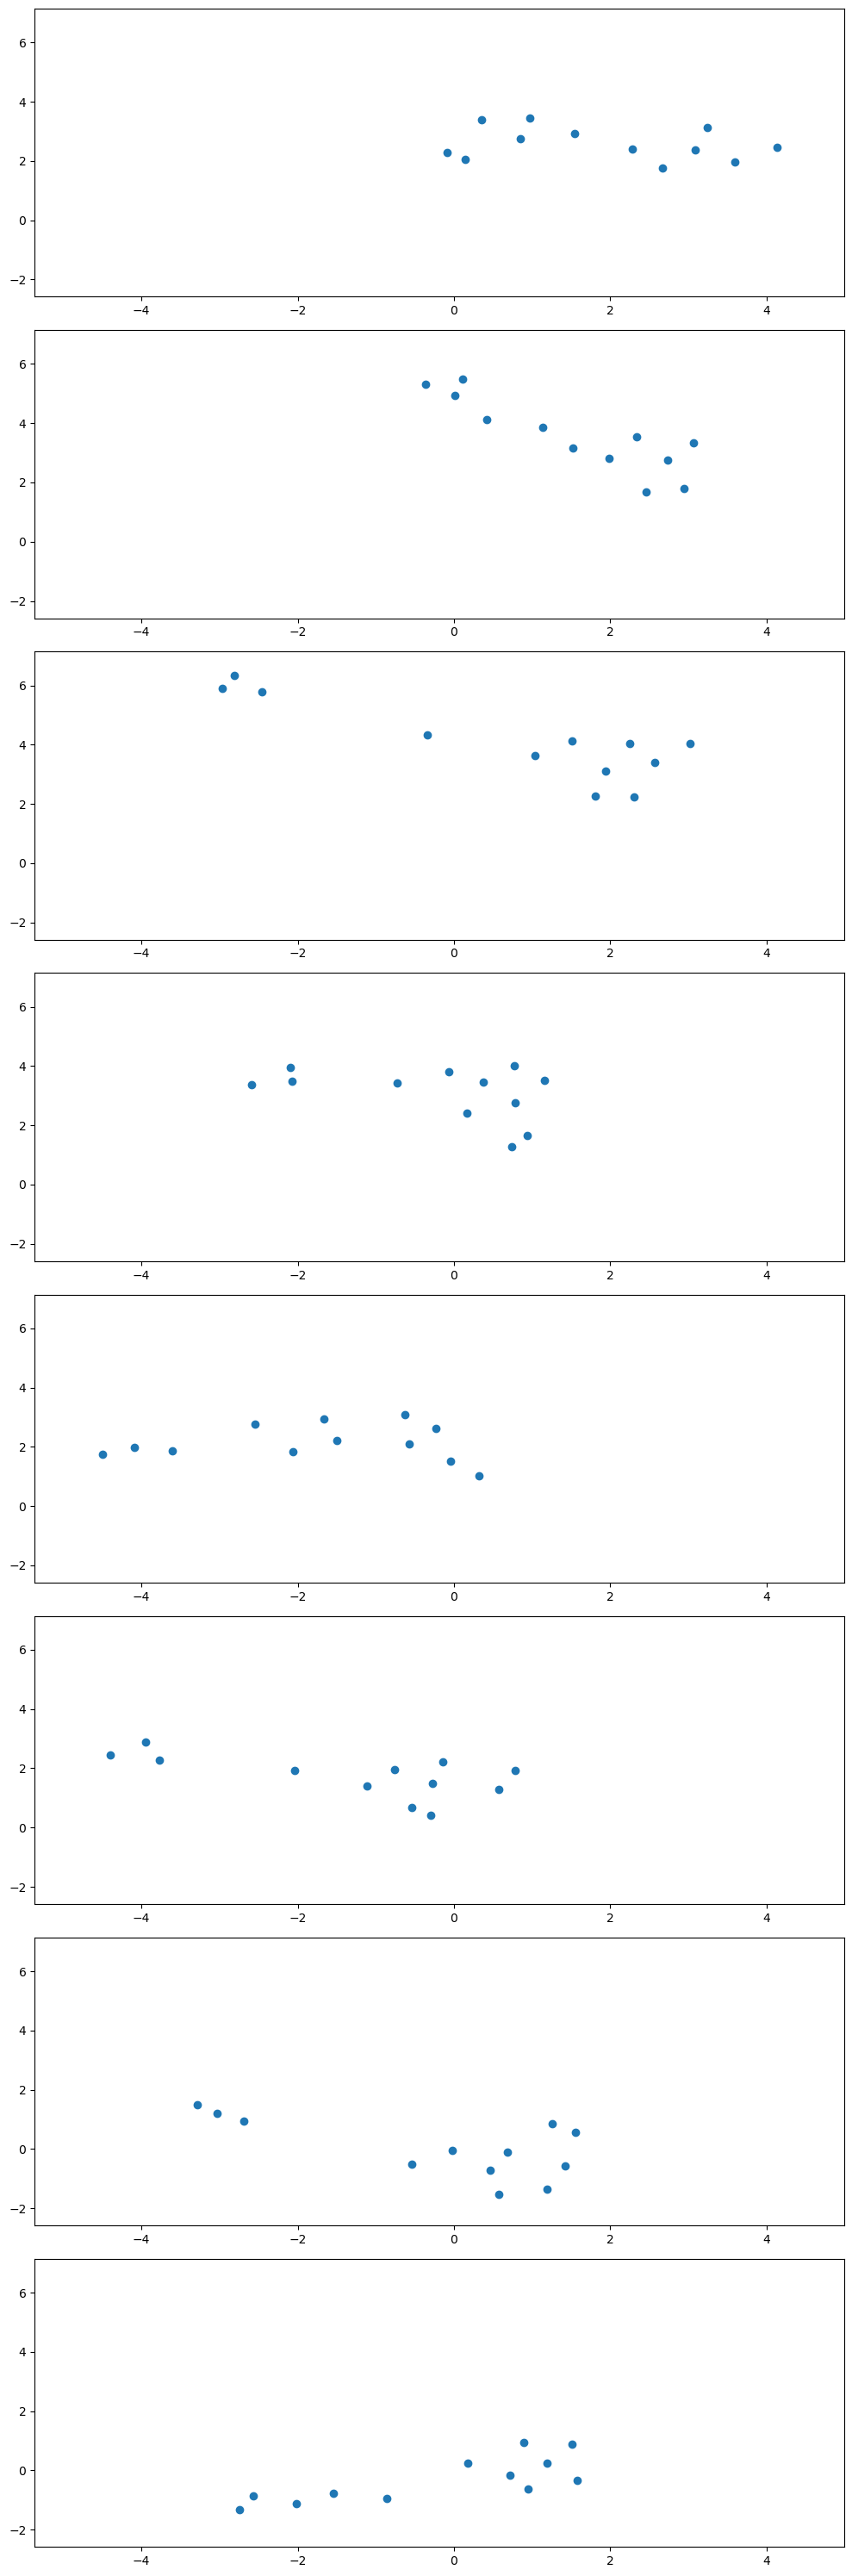

In [11]:
fig, axs = plt.subplots(8, 1, figsize=(10, 30))
ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
for i, ax in enumerate(axs.flatten()):
    ax.scatter(*aligned_mapper.embeddings_[i].T)
    ax.axis(ax_bound)
plt.tight_layout()
plt.show()

In [12]:
n_embeddings = len(aligned_mapper.embeddings_)
es = aligned_mapper.embeddings_
embedding_df = pd.DataFrame(np.vstack(es), columns=('x', 'y'))
embedding_df['z'] = np.repeat(np.linspace(0, 1.0, n_embeddings), es[0].shape[0])
embedding_df['id'] = np.tile(np.arange(es[0].shape[0]), n_embeddings)
#embedding_df['digit'] = np.tile(digits.target, n_embeddings)

fx = interp1d(
    embedding_df.z[embedding_df.id == 0]*10, embedding_df.x.values.reshape(n_embeddings, 12).T, kind="linear"
)
fy = interp1d(
    embedding_df.z[embedding_df.id == 0]*10, embedding_df.y.values.reshape(n_embeddings, 12).T, kind="linear"
)
z = np.linspace(0, 10, 100)

# viable colour palette's
#palette = px.colors.qualitative.Plotly * 2
# first couple of colours were edited to make them darker
palette = ['#ffa9d4', #'#fff7fb'
            '#a59ea8', #'#ece2f0'
            '#d0d1e6',
            '#a6bddb',
            '#67a9cf',
            '#3690c0',
            '#02818a',
            '#016c59',
            '#014636'] * 3

#'solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'
linetype = ['solid']*9 + ['dashdot']*9 + ['dashdot']*8

# work out the axis limits
x_min = embedding_df.x.min()
x_max = embedding_df.x.max()
y_min = embedding_df.y.min()
y_max = embedding_df.y.max()

x_midpoint = (x_min + x_max) / 2
y_midpoint = (y_min + y_max) / 2
x_len = x_max - x_min
y_len = y_max - y_min

max_length = max(x_len, y_len)

padding = 1.2

x_range = [x_midpoint - 0.5*max_length*padding, x_midpoint + 0.5*max_length*padding]
y_range = [y_midpoint - 0.5*max_length*padding, y_midpoint + 0.5*max_length*padding]


# start plotting
interpolated_traces = [fx(z), fy(z)]
traces = [
    go.Scatter3d(
        x=interpolated_traces[0][i],
        y=interpolated_traces[1][i],
        z=z*n_slices,
        mode="lines",
        line=dict(
            width=7.0,
            dash = linetype[i],
            color = palette[i]
        ),
        opacity=1,
        name = str(lookup.symptom_name_formatted.values[i]),
        text = str(lookup.symptom_name_formatted.values[i]),
        hovertext = str(lookup.symptom_name_formatted.values[i])
    )
    for i in range(12)
]
fig = go.Figure(data=traces)
fig.update_layout(
    width=1000,
    height=800,
    autosize=True,
    showlegend=True,
    legend = {'bgcolor': '#EAEAF2'},
    scene=(dict(
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=1.4), # can be used to stretch the plot vertically
        xaxis_range = x_range,
        yaxis_range = y_range,
        xaxis_title = 'UMAP 1',
        yaxis_title = 'UMAP 2',
        zaxis_title = 'Age (years)')))

fig.show()